In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)

# Загрузка данных

In [3]:
data = pd.read_csv('sobstv.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Жилая площадь, м^2              1500 non-null   float64
 1   Площадь кухни, м^2              1500 non-null   float64
 2   Общая площадь, м^2              1500 non-null   float64
 3   Этаж                            1500 non-null   int64  
 4   Стоимость, р.                   1500 non-null   int64  
 5   Количество комнат               1500 non-null   int64  
 6   Описание квартиры               1500 non-null   object 
 7   Фотографии                      1500 non-null   object 
 8   Тип жилья                       1499 non-null   object 
 9   Планировка                      811 non-null    object 
 10  Высота потолков                 612 non-null    object 
 11  Санузел                         1024 non-null   object 
 12  Ремонт                          14

# Подготовка данных

In [5]:
data.columns.tolist()

['Жилая площадь, м^2',
 'Площадь кухни, м^2',
 'Общая площадь, м^2',
 'Этаж',
 'Стоимость, р.',
 'Количество комнат',
 'Описание квартиры',
 'Фотографии',
 'Тип жилья',
 'Планировка',
 'Высота потолков',
 'Санузел',
 'Ремонт',
 'Вид из окон',
 'Балкон/лоджия',
 'Площадь комнат',
 'Отделка',
 'Количество пассажирских лифтов',
 'Год постройки',
 'Количество грузовых лифтов',
 'Количество этажей',
 'Технология строительства',
 'Широта',
 'Долгота',
 'Адрес, введенный пользователем',
 'Город',
 'Округ',
 'Район',
 'Улица',
 'Дом',
 'Станция метро',
 'Близость к метро',
 'Ссылка на объявление',
 'Дата публикации объявления',
 'Тип автора объявления']

In [6]:
target_columns = ['Жилая площадь, м^2',
 'Площадь кухни, м^2',
 'Общая площадь, м^2',
 'Этаж',
 'Стоимость, р.',
 'Количество комнат',
 'Тип жилья', 
 'Планировка',
 'Высота потолков',
 'Санузел',
 'Ремонт',
 'Вид из окон',
 'Балкон/лоджия',
 'Количество пассажирских лифтов',
 'Год постройки',
 'Количество грузовых лифтов',
 'Количество этажей',
 'Технология строительства',
 'Район',
 'Станция метро',
  'Широта',
  'Долгота'
]

In [7]:
data = data[target_columns]

In [8]:
data.shape

(1500, 22)

In [9]:
data.head(3)

,"Жилая площадь, м^2","Площадь кухни, м^2","Общая площадь, м^2",Этаж,"Стоимость, р.",Количество комнат,Тип жилья,Планировка,Высота потолков,Санузел,Ремонт,Вид из окон,Балкон/лоджия,Количество пассажирских лифтов,Год постройки,Количество грузовых лифтов,Количество этажей,Технология строительства,Район,Станция метро,Широта,Долгота
0,70.0,30.0,117.2,2,28800000,3,Вторичка,Смежно-изолированная,"2,77 м",1 раздельный,Без ремонта,На улицу,NaN,1,2016.0,1,9,monolith,Василеостровский,Василеостровская,59.929529,30.254001
1,75.0,15.0,132.1,3,39600000,3,Вторичка,Изолированная,NaN,1 раздельный,Евроремонт,На улицу и двор,1 балкон,1,NaN,0,5,brick,Петроградский,Петроградская,59.963796,30.303417
2,31.2,37.1,88.6,5,19492000,2,Вторичка,Изолированная,"2,73 м",2 совмещенных,Без ремонта,На улицу,NaN,1,2021.0,1,7,monolith,Выборгский,Лесная,59.997469,30.329774


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Жилая площадь, м^2              1500 non-null   float64
 1   Площадь кухни, м^2              1500 non-null   float64
 2   Общая площадь, м^2              1500 non-null   float64
 3   Этаж                            1500 non-null   int64  
 4   Стоимость, р.                   1500 non-null   int64  
 5   Количество комнат               1500 non-null   int64  
 6   Тип жилья                       1499 non-null   object 
 7   Планировка                      811 non-null    object 
 8   Высота потолков                 612 non-null    object 
 9   Санузел                         1024 non-null   object 
 10  Ремонт                          1499 non-null   object 
 11  Вид из окон                     1107 non-null   object 
 12  Балкон/лоджия                   10

## Обработка столбцов

In [11]:
data = data.fillna('nan')

In [12]:
def ceiling_height(string: str):
    if string == 'nan':
        return string
    else:
        string = string.split('м')[0].strip()
        return float(string)


data['Высота потолков'] = data['Высота потолков'].apply(
    lambda x: x.replace(',', '.'))

data['Высота потолков'] = data['Высота потолков'].apply(ceiling_height)

In [13]:
data_eda = data.copy()

In [14]:
data = data[data['Стоимость, р.'] <= 20000000]

In [15]:
target = data['Стоимость, р.']

data = data.drop('Стоимость, р.', axis=1)

In [16]:
data.head(3)

,"Жилая площадь, м^2","Площадь кухни, м^2","Общая площадь, м^2",Этаж,Количество комнат,Тип жилья,Планировка,Высота потолков,Санузел,Ремонт,Вид из окон,Балкон/лоджия,Количество пассажирских лифтов,Год постройки,Количество грузовых лифтов,Количество этажей,Технология строительства,Район,Станция метро,Широта,Долгота
2,31.2,37.1,88.6,5,2,Вторичка,Изолированная,2.73,2 совмещенных,Без ремонта,На улицу,nan,1,2021,1,7,monolith,Выборгский,Лесная,59.997469,30.329774
3,16.2,10.7,39.0,19,1,Вторичка,nan,2.6,1 совмещенный,Косметический,На улицу и двор,1 балкон,2,2015,1,27,monolithBrick,Выборгский,Парнас,60.081511,30.345477
4,0.0,10.0,71.8,8,3,Вторичка,nan,nan,1 раздельный,Евроремонт,Во двор,1 лоджия,1,1988,0,9,panel,Приморский,Комендантский проспект,60.015709,30.253507


## Деление данных

In [17]:
X_train, X_rem, y_train, y_rem = train_test_split(
    data,
    target,
    train_size=0.8,
    random_state=42,
    shuffle=True,
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem,
    y_rem,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_valid.shape, y_valid.shape

((1160, 21), (146, 21), (1160,), (146,), (145, 21), (145,))

In [19]:
train_dataset  = Pool(
    data=X_train,
    label=y_train,
    cat_features=[
        'Тип жилья', 'Планировка', 'Санузел', 'Ремонт', 
        'Вид из окон', 'Балкон/лоджия', 'Технология строительства', 'Район', 
        'Станция метро',
    ],
)

valid_dataset  = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=[
        'Тип жилья', 'Планировка', 'Санузел', 'Ремонт', 
        'Вид из окон', 'Балкон/лоджия', 'Технология строительства', 'Район', 
        'Станция метро',
    ],
)

test_dataset = Pool(
    data=X_test,
    label=y_test,
    cat_features=[
        'Тип жилья', 'Планировка', 'Санузел', 'Ремонт', 
        'Вид из окон', 'Балкон/лоджия', 'Технология строительства', 'Район', 
        'Станция метро',
    ],
)

# EDA

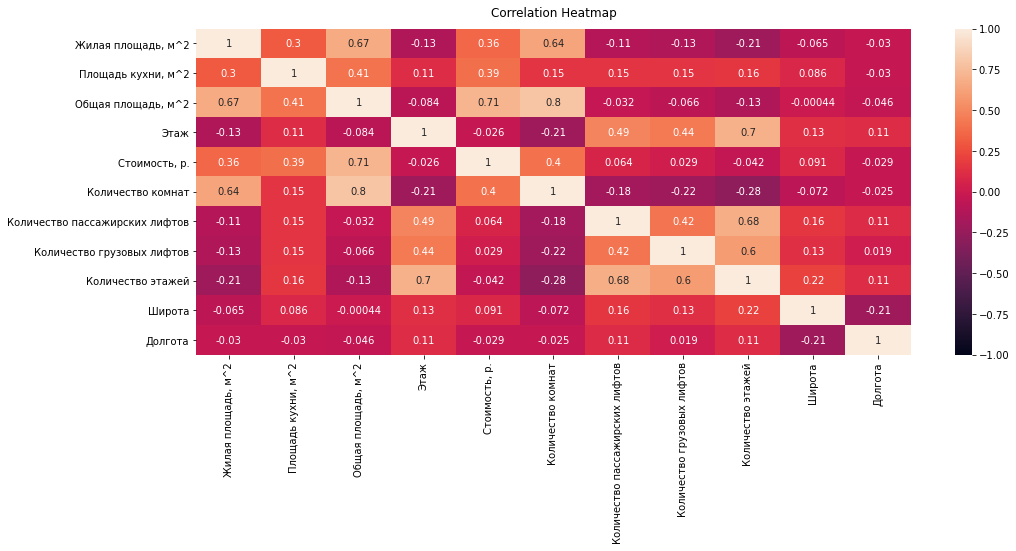

In [20]:
corr_pearson = data_eda.corr(method='pearson')
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_pearson, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Стоимость, р.'>

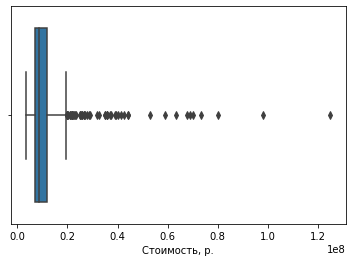

In [21]:
sns.boxplot(data_eda['Стоимость, р.'])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='Стоимость, р.', ylabel='Density'>

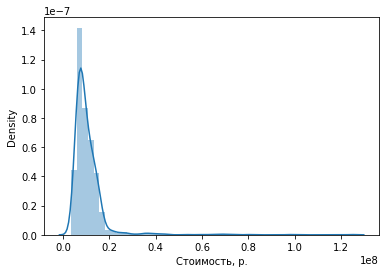

In [22]:
sns.distplot(data_eda['Стоимость, р.'])

In [23]:
data_eda[data_eda['Стоимость, р.'] > 20000000].shape

(49, 22)

# Обучение модели

In [24]:
ctb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    random_seed=42,
    depth=5,
    task_type="CPU",
    loss_function='RMSE',
    l2_leaf_reg=10,
    use_best_model=True,
    bagging_temperature=1000,
)

In [25]:
ctb.fit(
    train_dataset,
    eval_set=valid_dataset,
    plot=True,
    early_stopping_rounds=10,
    verbose=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3117105.7114085	test: 3009891.4097941	best: 3009891.4097941 (0)	total: 154ms	remaining: 2m 33s
1:	learn: 3002992.4175831	test: 2905750.4415047	best: 2905750.4415047 (1)	total: 163ms	remaining: 1m 21s
2:	learn: 2893655.1723076	test: 2807202.0341756	best: 2807202.0341756 (2)	total: 172ms	remaining: 57.1s
3:	learn: 2796363.5834761	test: 2709940.9427774	best: 2709940.9427774 (3)	total: 181ms	remaining: 45.1s
4:	learn: 2698471.3012283	test: 2606188.8906527	best: 2606188.8906527 (4)	total: 190ms	remaining: 37.8s
5:	learn: 2609961.3935402	test: 2533102.0094409	best: 2533102.0094409 (5)	total: 199ms	remaining: 33s
6:	learn: 2517184.7286064	test: 2445474.5598679	best: 2445474.5598679 (6)	total: 208ms	remaining: 29.5s
7:	learn: 2459072.6452578	test: 2392459.3817008	best: 2392459.3817008 (7)	total: 217ms	remaining: 26.9s
8:	learn: 2386531.9916031	test: 2324334.8079545	best: 2324334.8079545 (8)	total: 225ms	remaining: 24.7s
9:	learn: 2331511.2774012	test: 2272052.1436720	best: 2272052.14

86:	learn: 1388169.0395761	test: 1460085.7101976	best: 1459729.8008631 (85)	total: 907ms	remaining: 9.52s
87:	learn: 1387895.4053844	test: 1460049.9963532	best: 1459729.8008631 (85)	total: 916ms	remaining: 9.49s
88:	learn: 1382261.3939852	test: 1454961.9015872	best: 1454961.9015872 (88)	total: 924ms	remaining: 9.46s
89:	learn: 1382039.4553975	test: 1454937.3642838	best: 1454937.3642838 (89)	total: 931ms	remaining: 9.41s
90:	learn: 1381823.3032997	test: 1454915.3329910	best: 1454915.3329910 (90)	total: 939ms	remaining: 9.38s
91:	learn: 1377067.0227361	test: 1455121.6021865	best: 1454915.3329910 (90)	total: 948ms	remaining: 9.35s
92:	learn: 1376679.8162829	test: 1455158.6249650	best: 1454915.3329910 (90)	total: 956ms	remaining: 9.33s
93:	learn: 1376250.2108988	test: 1455204.0794341	best: 1454915.3329910 (90)	total: 965ms	remaining: 9.3s
94:	learn: 1369919.4736244	test: 1451021.3718826	best: 1451021.3718826 (94)	total: 979ms	remaining: 9.33s
95:	learn: 1365245.7143989	test: 1450354.194297

172:	learn: 1233726.1355386	test: 1396178.6363308	best: 1395098.4418543 (171)	total: 1.66s	remaining: 7.93s
173:	learn: 1230621.6004752	test: 1396716.7779095	best: 1395098.4418543 (171)	total: 1.67s	remaining: 7.92s
174:	learn: 1228048.8955289	test: 1398381.7919499	best: 1395098.4418543 (171)	total: 1.68s	remaining: 7.91s
175:	learn: 1226619.8195621	test: 1397124.1097044	best: 1395098.4418543 (171)	total: 1.69s	remaining: 7.89s
176:	learn: 1224823.6428132	test: 1397738.2206009	best: 1395098.4418543 (171)	total: 1.69s	remaining: 7.88s
177:	learn: 1224617.2936436	test: 1397737.2578587	best: 1395098.4418543 (171)	total: 1.7s	remaining: 7.87s
178:	learn: 1221618.6921272	test: 1397219.9394720	best: 1395098.4418543 (171)	total: 1.71s	remaining: 7.86s
179:	learn: 1221144.6138578	test: 1398142.9162397	best: 1395098.4418543 (171)	total: 1.72s	remaining: 7.84s
180:	learn: 1218782.8683957	test: 1397810.0219809	best: 1395098.4418543 (171)	total: 1.73s	remaining: 7.82s
181:	learn: 1218269.3627569	t

# Оценка качества модели

In [26]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
y_train_pred = ctb.predict(train_dataset)
y_valid_pred = ctb.predict(valid_dataset)
y_test_pred = ctb.predict(test_dataset)


train_mape = round(mape(y_train, y_train_pred), 2)
valid_mape = round(mape(y_valid, y_valid_pred), 2)
test_mape = round(mape(y_test, y_test_pred), 2)


print(f"Train MAPE: {train_mape} %")
print(f"Valid MAPE: {valid_mape} %")
print(f"Test MAPE: {test_mape} %")

Train MAPE: 9.72 %
Valid MAPE: 11.52 %
Test MAPE: 12.0 %


# Интерпретация результатов

In [28]:
explainer = shap.TreeExplainer(ctb)

shap_values = explainer(X_train)

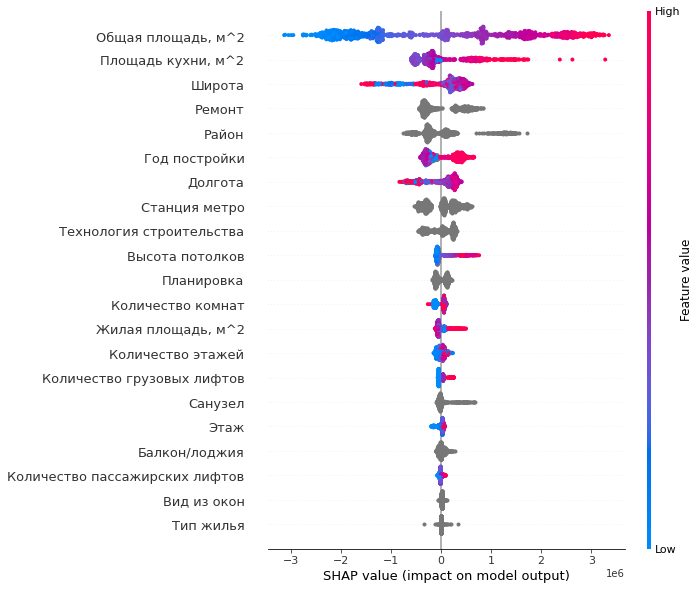

In [29]:
shap.summary_plot(shap_values, max_display=X_train.shape[1])

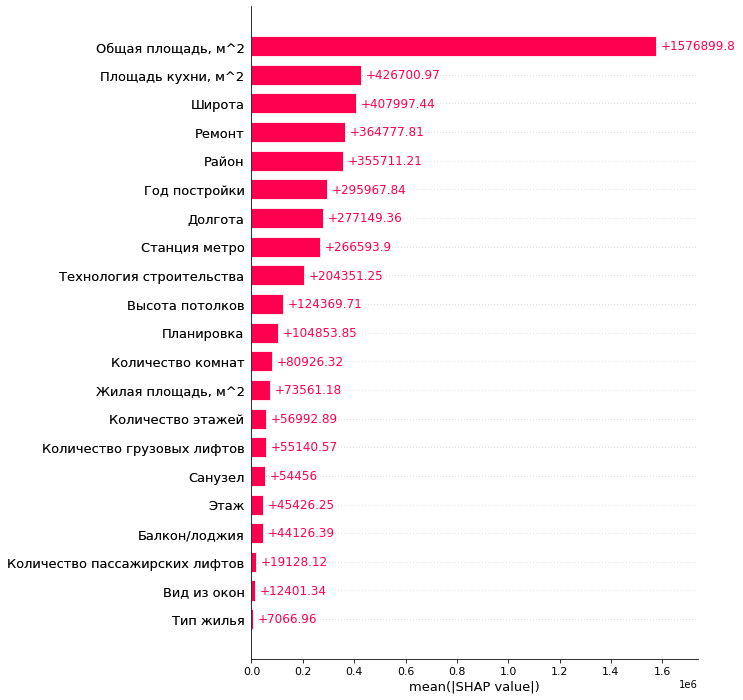

In [30]:
shap.plots.bar(shap_values, max_display=X_train.shape[1])

In [31]:
data['Ремонт'].value_counts()

Косметический    633
Евроремонт       403
Без ремонта      249
Дизайнерский     165
nan                1
Name: Ремонт, dtype: int64

In [32]:
one_example = pd.DataFrame()

features = {
'Жилая площадь, м^2': 27.6,
'Площадь кухни, м^2': 15.6,
'Общая площадь, м^2': 36.98,
'Этаж': 12,
'Количество комнат': 1,
'Тип жилья': 'Вторичка' ,
'Планировка': 'Смежная', 
'Высота потолков': 2.56,
'Санузел': '1 совмещенный',
'Ремонт': 'Косметический',
'Вид из окон': 'На улицу',
'Балкон/лоджия': '1 балкон',
'Количество пассажирских лифтов': 2,
'Год постройки': 2020,
'Количество грузовых лифтов': 1,
'Количество этажей': 26,
'Технология строительства': 'panel',
'Район': 'Невский',
'Станция метро': 'Дыбенко',
'Широта': 59.899100,
'Долгота': 30.450554,
}

one_example = pd.DataFrame([features])

one_example

,"Жилая площадь, м^2","Площадь кухни, м^2","Общая площадь, м^2",Этаж,Количество комнат,Тип жилья,Планировка,Высота потолков,Санузел,Ремонт,Вид из окон,Балкон/лоджия,Количество пассажирских лифтов,Год постройки,Количество грузовых лифтов,Количество этажей,Технология строительства,Район,Станция метро,Широта,Долгота
0,27.6,15.6,36.98,12,1,Вторичка,Смежная,2.56,1 совмещенный,Косметический,На улицу,1 балкон,2,2020,1,26,panel,Невский,Дыбенко,59.8991,30.450554


In [33]:
ctb.predict(one_example)

array([8330912.07051841])

In [34]:
shap.initjs()

shap_values = explainer(one_example)


shap.plots.force(shap_values[0])